# 合成データセット作り直し

## 共通事項
- 各クラス1500個 データ作成
- 4class : 0_BA, 1_Attach, 2_Growth, 3: Random

## 保存すること
- パラメータ保存
- ネットワーク保存
- ネットワーク特徴量保存
- 画像保存 (shuffle, sort)
- geometric tensor 保存

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.utils import from_networkx
from test_utils import network_info
from reserch_utils_HT import network_to_image
from reserch_utils_HT import no_growth, no_preferential_attachment

In [2]:
def make_save_folder(dataset_name, kind):
    """ 保存先フォルダ作成 """
    kind_to_name = {"BA": "0_BA", "Attach": "1_Attach", "Growth": "2_Growth", "Random": "3_Random"}
    # graph
    os.makedirs(f"../graph_data/{dataset_name}/graph/{kind_to_name[kind]}", exist_ok=True)       
    # image
    os.makedirs(f"../graph_data/{dataset_name}/shuffle/pics/{kind_to_name[kind]}", exist_ok=True)
    os.makedirs(f"../graph_data/{dataset_name}/sort/pics/{kind_to_name[kind]}", exist_ok=True)
    # graph tensor
    os.makedirs(f"../graph_data/{dataset_name}/graph_tensor/edge", exist_ok=True)
    os.makedirs(f"../graph_data/{dataset_name}/graph_tensor/x", exist_ok=True)
    os.makedirs(f"../graph_data/{dataset_name}/graph_tensor/y", exist_ok=True)
    

def make_net_img(kind, node, parameter, seed):
    """ グラフ生成 & 画像化 """
    # generate graph
    if kind == "BA":
        G = nx.barabasi_albert_graph(node, parameter, seed=seed)
    elif kind == "Attach":
        G = no_growth(node, parameter, seed=seed)
    elif kind == "Growth":
        G = no_preferential_attachment(node, parameter, seed=seed)
    else:
        G = nx.gnp_random_graph(node, parameter, seed=seed)
    # network to image
    shuffle_img = network_to_image(G, shuffle=True)
    sort_img = network_to_image(G, sort=True)
    return G, shuffle_img, sort_img

def graph_to_geometricTensor(G, kind):
    """ graph -> GNN用データ 変換"""
    kind_to_label = {"BA": 0, "Attach": 1, "Growth": 2, "Random": 3}
    # graph to torch geometric data
    data = from_networkx(G)

    # set node attribute
    data.x = torch.tensor(
        [[d] for d in list(dict(G.degree()).values())],
        dtype=torch.float,
    )
    # set graph label
    data.y = torch.tensor([kind_to_label[kind]])
    return data

def make_save(kind, node, parameter, seed, dataset_name):
    """ 各種生成から保存まで """
    kind_to_name = {"BA": "0_BA", "Attach": "1_Attach", "Growth": "2_Growth", "Random": "3_Random"}
    
    pls_num = {"BA": 0, "Attach": 1000, "Growth": 2000, "Random": 3000}
    
    G, shuffle_img, sort_img = make_net_img(kind, node, parameter, seed)
    # graph save
    nx.write_adjlist(G, f"../graph_data/{dataset_name}/graph/{kind_to_name[kind]}/{seed}.adjlist")
    # image save
    shuffle_img.save(f"../graph_data/{dataset_name}/shuffle/pics/{kind_to_name[kind]}/{seed}.png")
    sort_img.save(f"../graph_data/{dataset_name}/sort/pics/{kind_to_name[kind]}/{seed}.png")
    # tensor save
    data_tensor = graph_to_geometricTensor(G, kind)
    torch.save(data_tensor.edge_index, f"../graph_data/{dataset_name}/graph_tensor/edge/{seed+pls_num[kind]}.pt")
    torch.save(data_tensor.x, f"../graph_data/{dataset_name}/graph_tensor/x/{seed+pls_num[kind]}.pt")    
    torch.save(data_tensor.y, f"../graph_data/{dataset_name}/graph_tensor/y/{seed+pls_num[kind]}.pt")
    
    info = network_info(G)
    info["kind"] = kind
    info["parameter"] = parameter
    info["node"] = node
    info["seed"] = seed
    
    return info

# Subset
ノード数100固定

各クラス内のエッジ数が同程度のデータセット  
-> パラメータを固定して同程度にする

### parameters
- (BA, Attach, Growth, Random) = (2, 200, 2, 0.04)

In [3]:
dataset_name = "subset1"
node = 100

df = pd.DataFrame() # dataset info 保存用
cnt = 0
# BA
make_save_folder(dataset_name, "BA")
for i in tqdm(range(1000)):
    info = make_save("BA", node, 2, i, dataset_name)
    df = df.append(pd.Series(info, name=cnt))
    cnt += 1
# Attach
make_save_folder(dataset_name, "Attach")
for i in tqdm(range(1000)):
    info = make_save("Attach", node, 200, i, dataset_name)
    df = df.append(pd.Series(info, name=cnt))
    cnt += 1
# Growth
make_save_folder(dataset_name, "Growth")
for i in tqdm(range(1000)):
    info = make_save("Growth", node, 2, i, dataset_name)
    df = df.append(pd.Series(info, name=cnt))
    cnt += 1
# Random
make_save_folder(dataset_name, "Random")
for i in tqdm(range(1000)):
    info = make_save("Random", node, 0.04, i, dataset_name)
    df = df.append(pd.Series(info, name=cnt))
    cnt += 1

df.to_csv(f"../graph_data/{dataset_name}/data_info.csv")

100%|██████████| 1000/1000 [00:09<00:00, 107.48it/s]


# Poisson
パラメータだけ乱数により生成
ノード数100固定

## parameter setting
- BA : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Attach : $1*node \leq step \leq 10*node$ 平均 5, 分散 1 の正規分布から生成
- Growth : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Random : $0.04\leq p \leq 0.18$ 平均 0.1 分散 0.02 の正規分布から生成

In [3]:
# parameter list 作成
p_rand = np.random.normal(0.1, 0.02, 1000)
param = np.random.normal(5, 1, 10000).astype(int)
ba_rand =[]
for m in param:
    if 2 <= m <= 10:
        ba_rand.append(m)
    if len(ba_rand) == 1000:
        break
        
param = np.random.normal(5, 1, 10000).astype(int)
growth_rand =[]
for m in param:
    if 2 <= m <= 10:
        growth_rand.append(m)
    if len(growth_rand) == 1000:
        break

param = np.random.normal(5, 1, 10000).astype(int)
step_rand =[]
for m in param:
    if 1 <= m <= 10:
        step_rand.append(m)
    if len(step_rand) == 1000:
        break

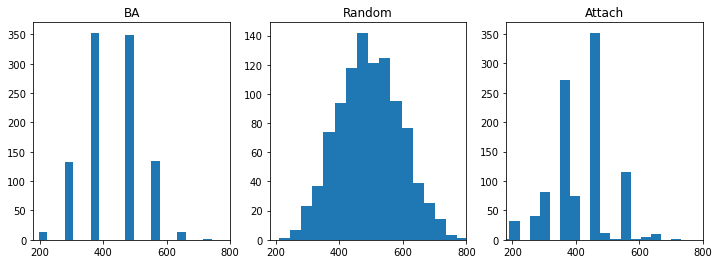

In [4]:
# エッジ分布 確認
fig, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].hist([nx.number_of_edges(nx.barabasi_albert_graph(100, p)) for p in ba_rand], bins=20)
axes[0].set_title("BA")
axes[1].hist([nx.number_of_edges(nx.gnp_random_graph(100, p)) for p in p_rand], bins=20)
axes[1].set_title("Random")
axes[2].hist([nx.number_of_edges(no_growth(100, 100*p)) for p in step_rand], bins=20)
axes[2].set_title("Attach")

for i in range(3):
    axes[i].set_xlim(180, 800)

plt.show()

In [8]:
df.query("kind=='Attach'").parameter

1000    5.0
1001    3.0
1002    5.0
1003    5.0
1004    5.0
       ... 
1995    6.0
1996    4.0
1997    4.0
1998    3.0
1999    5.0
Name: parameter, Length: 1000, dtype: float64

In [9]:
dataset_name = "poisson"
node = 100

df = pd.DataFrame() # dataset info 保存用
cnt = 0
# BA
for kind in ["BA", "Attach", "Growth", "Random"]:
    params = {"BA": ba_rand, "Attach": step_rand, "Growth": growth_rand, "Random": p_rand}
    make_save_folder(dataset_name, kind)
    for i, p in tqdm(enumerate(params[kind])):
        if kind == "Attach":
            info = make_save(kind, node, p*100, i, dataset_name)
        else:
            info = make_save(kind, node, p, i, dataset_name)
        df = df.append(pd.Series(info, name=cnt))
        cnt += 1

df.to_csv(f"../graph_data/poisson/data_info.csv")

1000it [00:18, 53.81it/s]
1000it [01:30, 11.04it/s]
1000it [00:25, 38.90it/s]
1000it [00:19, 50.44it/s]


# new poisson
ノード数, パラメータともに乱数により決定
## parameter settings

### new poisson
- ノード数 : 平均 100, 分散 10, 正規分布
- BA : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Attach : $1*node \leq step \leq 10*node$ 平均 2, 分散 1 の正規分布から生成
- Growth : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Random : $0.04\leq p \leq 0.18$ 平均 0.1 分散 0.02 の正規分布から生成

### new_pareto
- ノード数 : shape 2, scale 30 パレート分布
- BA : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Attach : $1*node \leq step \leq 10*node$ 平均 2, 分散 1 の正規分布から生成
- Growth : $2\leq m \leq 10$, 平均 5, 分散 1 の正規分布から生成
- Random : $0.04\leq p \leq 0.18$ 平均 0.1 分散 0.02 の正規分布から生成

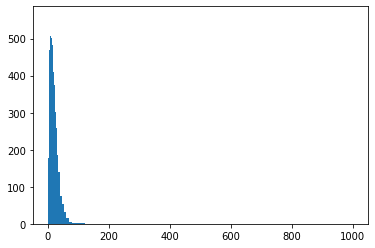

In [42]:
rand_exp_scale = 10.0
rand_exp_size = 10000
rand_exp = np.random.exponential(scale=rand_exp_scale, size=rand_exp_size)

plt.hist(rand_exp, bins=np.logspace(0, 3, 50))
# plt.xscale("log")
# plt.yscale("log")

plt.show()

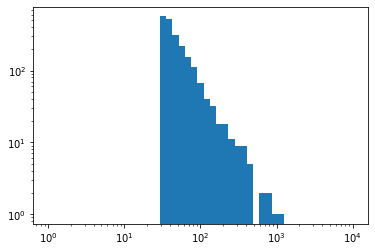

In [77]:
a, m = 2., 30.  # 分布の幅と、モードを指定   
s = (np.random.pareto(a, 2090) + 1) * m
plt.hist(s, bins=np.logspace(0, 4, 50))
plt.xscale("log")
plt.yscale("log")

plt.show()

In [68]:
s

array([31.51500134, 41.89030232, 56.97604259, ..., 32.5093487 ,
       47.5561703 , 67.02782936])

In [7]:
# parameter list 作成

node_list = np.random.normal(100, 30, 2000).astype(int)
p_rand = np.random.normal(0.1, 0.02, 1000)
param = np.random.normal(5, 1, 10000).astype(int)

# BA
ba_rand =[]
for n, m in zip(node_list, param):
    if 2 <= m <= 10:
        if 10 < n:
            ba_rand.append((n, m))
    if len(ba_rand) == 1000:
        break

# Growth
node_list = np.random.normal(100, 30, 2000).astype(int)
param = np.random.normal(5, 1, 10000).astype(int)
growth_rand =[]
for n, m in zip(node_list, param):
    if 2 <= m <= 10:
        if 10 < n:
            growth_rand.append((n, m))
    if len(growth_rand) == 1000:
        break

# Attach
node_list = np.random.normal(100, 30, 2000).astype(int)
param = np.random.normal(5, 1, 10000).astype(int)
step_rand =[]
for n, m in zip(node_list, param):
    if 1 <= m <= 10:
        if 10 < n:
            step_rand.append((n,m*n))
    if len(step_rand) == 1000:
        break

# Random
node_list = np.random.normal(100, 30, 2000).astype(int)
p_rand = np.random.normal(0.1, 0.02, 2000)
random_rand =[]
for n, m in zip(node_list, p_rand):
    if 10 < n:
        random_rand.append((n,m))
    if len(random_rand) == 1000:
        break

In [8]:
dataset_name = "new_poisson"

df = pd.DataFrame() # dataset info 保存用
cnt = 0
# BA
for kind in ["BA", "Attach", "Growth", "Random"]:
    params = {"BA": ba_rand, "Attach": step_rand, "Growth": growth_rand, "Random": random_rand}
    make_save_folder(dataset_name, kind)
    for i, (n, p) in tqdm(enumerate(params[kind])):
        info = make_save(kind, n, p, i, dataset_name)
            
        df = df.append(pd.Series(info, name=cnt))
        cnt += 1

df.to_csv(f"../graph_data/{dataset_name}/data_info.csv")

1000it [00:18, 53.67it/s]
1000it [01:35, 10.52it/s]
1000it [00:25, 38.87it/s]
1000it [00:20, 48.23it/s]


In [78]:
# parete
a, m = 2., 30.  # 分布の幅と、モードを指定   

s = (np.random.pareto(a, 5000) + 1) * m
# parameter list 作成
node_list = s.astype(int)
p_rand = np.random.normal(0.1, 0.02, 1000)
param = np.random.normal(5, 1, 10000).astype(int)

# BA
ba_rand =[]
for n, m in zip(node_list, param):
    if 2 <= m <= 10:
        if 10 < n:
            ba_rand.append((n, m))
    if len(ba_rand) == 1000:
        break

a, m = 2., 30.  # 分布の幅と、モードを指定   
# Growth
s = (np.random.pareto(a, 5000) + 1) * m
node_list = s.astype(int)
param = np.random.normal(5, 1, 10000).astype(int)
growth_rand =[]
for n, m in zip(node_list, param):
    if 2 <= m <= 10:
        if 10 < n:
            growth_rand.append((n, m))
    if len(growth_rand) == 1000:
        break

# Attach
a, m = 2., 30.  # 分布の幅と、モードを指定   
s = (np.random.pareto(a, 5000) + 1) * m

node_list = s.astype(int)
param = np.random.normal(5, 1, 10000).astype(int)
step_rand =[]
for n, m in zip(node_list, param):
    if 1 <= m <= 10:
        if 10 < n:
            step_rand.append((n,m*n))
    if len(step_rand) == 1000:
        break

# Random
a, m = 2., 30.  # 分布の幅と、モードを指定   
s = (np.random.pareto(a, 5000) + 1) * m
node_list = s.astype(int)
p_rand = np.random.normal(0.1, 0.02, 2000)
random_rand =[]
for n, m in zip(node_list, p_rand):
    if 10 < n:
        random_rand.append((n,m))
    if len(random_rand) == 1000:
        break


# make
dataset_name = "new_parete"

df = pd.DataFrame() # dataset info 保存用
cnt = 0
# BA
for kind in ["BA", "Attach", "Growth", "Random"]:
    params = {"BA": ba_rand, "Attach": step_rand, "Growth": growth_rand, "Random": random_rand}
    make_save_folder(dataset_name, kind)
    for i, (n, p) in tqdm(enumerate(params[kind])):
        info = make_save(kind, n, p, i, dataset_name)
            
        df = df.append(pd.Series(info, name=cnt))
        cnt += 1

df.to_csv(f"../graph_data/{dataset_name}/data_info.csv")

1000it [01:12, 13.88it/s]
1000it [00:58, 17.20it/s]
1000it [00:16, 60.03it/s]
1000it [00:18, 53.14it/s]


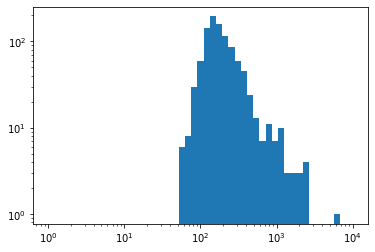

In [83]:
plt.hist(df.query('kind=="BA"').edges, bins=np.logspace(0, 4, 50))
plt.xscale("log")
plt.yscale("log")